#1. Install kagglehub and dependencies and download dataset

In [5]:
!pip install -q kagglehub scikit-learn pandas matplotlib

import kagglehub

# Download the latest Breast Cancer Wisconsin (Diagnostic) dataset
path = kagglehub.dataset_download("uciml/breast-cancer-wisconsin-data")
print("Dataset folder:", path)

Using Colab cache for faster access to the 'breast-cancer-wisconsin-data' dataset.
Dataset folder: /kaggle/input/breast-cancer-wisconsin-data


#2. Load and clean dataset



In [6]:
import pandas as pd
import os

# Locate the actual CSV file
csv_files = [f for f in os.listdir(path) if f.endswith(".csv")]
assert len(csv_files) > 0, "No CSV file found in dataset path."
csv_path = os.path.join(path, csv_files[0])
print("CSV file:", csv_path)

# Load and clean dataset
df = pd.read_csv(csv_path)
for col in ["id", "Unnamed: 32"]:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

# Map target column
df["diagnosis"] = df["diagnosis"].map({"M": 1, "B": 0})
print("Shape:", df.shape)
df.head()

CSV file: /kaggle/input/breast-cancer-wisconsin-data/data.csv
Shape: (569, 31)


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


#3. Train/test split + standardize features

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop(columns=["diagnosis"])
y = df["diagnosis"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

#4. Logistic Regression (classification)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    ConfusionMatrixDisplay, RocCurveDisplay
)

# Fit model
logreg = LogisticRegression(solver="liblinear", penalty="l2", max_iter=1000, random_state=42)
logreg.fit(X_train_scaled, y_train)

# Evaluate
y_pred = logreg.predict(X_test_scaled)
y_proba = logreg.predict_proba(X_test_scaled)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy={acc:.3f}, Precision={prec:.3f}, Recall={rec:.3f}, F1={f1:.3f}, ROC AUC={auc:.3f}")

Accuracy=0.974, Precision=0.976, Recall=0.952, F1=0.964, ROC AUC=0.996


#5. Visualize results

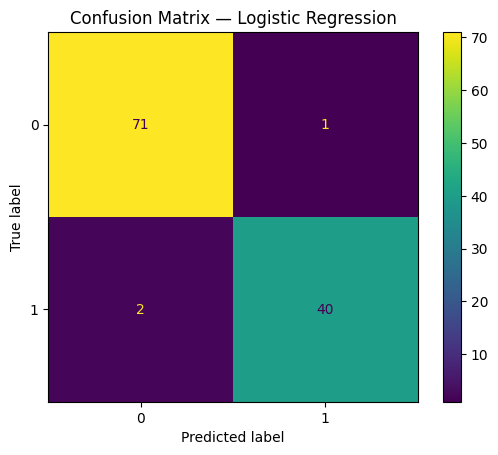

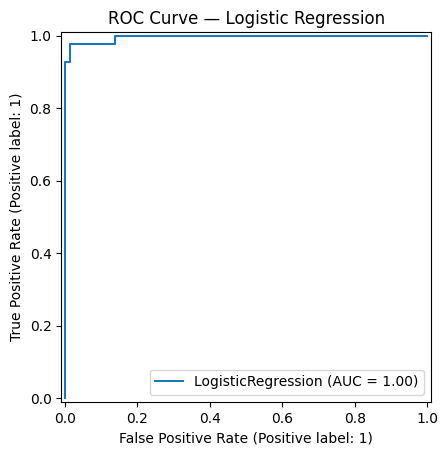

In [9]:
# Confusion matrix
ConfusionMatrixDisplay.from_estimator(logreg, X_test_scaled, y_test)
plt.title("Confusion Matrix — Logistic Regression")
plt.show()

# ROC curve
RocCurveDisplay.from_estimator(logreg, X_test_scaled, y_test)
plt.title("ROC Curve — Logistic Regression")
plt.show()

#6. Interpret coefficients (log-odds)

In [10]:
coef = pd.Series(logreg.coef_[0], index=X.columns)
odds_ratio = np.exp(coef)
coef_df = pd.DataFrame({
    "feature": X.columns,
    "beta": coef.values,
    "odds_ratio": odds_ratio.values,
    "abs_beta": np.abs(coef.values)
}).sort_values("abs_beta", ascending=False)

# Show top 15
coef_df.head(15)

,feature,beta,odds_ratio,abs_beta
21,texture_worst,1.423806,4.152896,1.423806
10,radius_se,1.243632,3.468188,1.243632
28,symmetry_worst,1.059102,2.883780,1.059102
7,concave points_mean,0.954814,2.598186,0.954814
13,area_se,0.933406,2.543156,0.933406
23,area_worst,0.924092,2.519580,0.924092
15,compactness_se,-0.915840,0.400180,0.915840
26,concavity_worst,0.910627,2.485880,0.910627
20,radius_worst,0.896585,2.451218,0.896585
6,concavity_mean,0.790535,2.204576,0.790535


#7. Plot top-|β| features

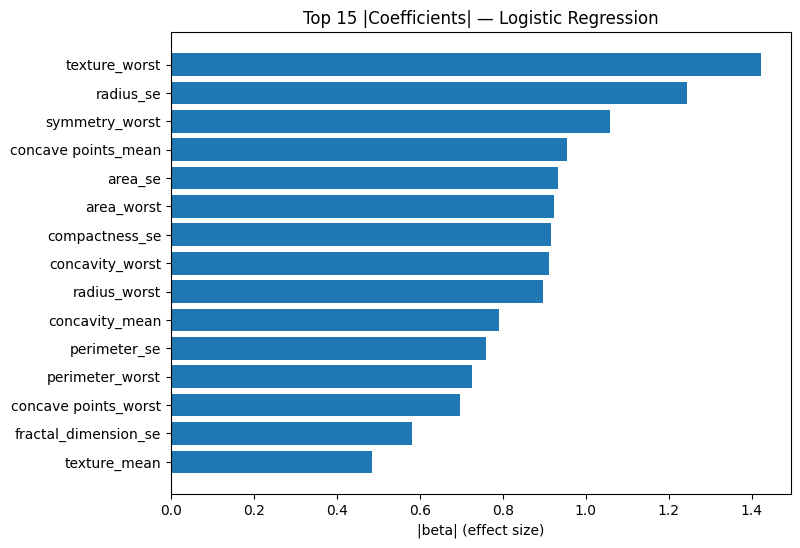

In [11]:
top = coef_df.head(15).sort_values("abs_beta")
plt.figure(figsize=(8,6))
plt.barh(top["feature"], top["abs_beta"])
plt.xlabel("|beta| (effect size)")
plt.title("Top 15 |Coefficients| — Logistic Regression")
plt.show()

#8. Save & copy figures and tables to drive

In [13]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, precision_recall_curve
from google.colab import drive

# 1) ensure folders
os.makedirs("outputs/figures", exist_ok=True)
os.makedirs("outputs/tables", exist_ok=True)

# 2) tables
metrics_df = pd.DataFrame([{
    "Model": "Logistic Regression",
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred),
    "ROC AUC": roc_auc_score(y_test, y_proba)
}])
metrics_df.to_csv("outputs/tables/model_performance_summary.csv", index=False)
coef_df.to_csv("outputs/tables/logreg_coefficients.csv", index=False)

# 3) figures
# Confusion matrix
fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_estimator(logreg, X_test_scaled, y_test, ax=ax)
ax.set_title("Confusion Matrix — Logistic Regression")
fig.savefig("outputs/figures/confusion_matrix_logreg.png", bbox_inches="tight")
plt.close(fig)

# ROC curve
fig, ax = plt.subplots()
RocCurveDisplay.from_estimator(logreg, X_test_scaled, y_test, ax=ax)
ax.set_title("ROC Curve — Logistic Regression")
fig.savefig("outputs/figures/roc_logreg.png", bbox_inches="tight")
plt.close(fig)

# Top |beta| bar chart
top = coef_df.head(min(15, coef_df.shape[0])).sort_values("abs_beta")
fig, ax = plt.subplots(figsize=(8,6))
ax.barh(top["feature"], top["abs_beta"])
ax.set_xlabel("|beta| (absolute effect size)")
ax.set_title("Top 15 |Coefficients| — Logistic Regression")
fig.tight_layout()
fig.savefig("outputs/figures/logreg_top_abs_coefs.png", bbox_inches="tight")
plt.close(fig)

# Precision/Recall vs threshold
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba, pos_label=1)

fig, ax = plt.subplots()
ax.plot(thresholds, recalls[:-1])
ax.set_xlabel("Threshold"); ax.set_ylabel("Recall")
ax.set_title("Recall vs Threshold — Logistic Regression")
fig.savefig("outputs/figures/recall_vs_threshold.png", bbox_inches="tight")
plt.close(fig)

fig, ax = plt.subplots()
ax.plot(thresholds, precisions[:-1])
ax.set_xlabel("Threshold"); ax.set_ylabel("Precision")
ax.set_title("Precision vs Threshold — Logistic Regression")
fig.savefig("outputs/figures/precision_vs_threshold.png", bbox_inches="tight")
plt.close(fig)

# 4) copy to Google Drive
drive.mount('/content/drive', force_remount=True)
!mkdir -p /content/drive/MyDrive/midterm_outputs
!cp -r outputs /content/drive/MyDrive/midterm_outputs

print("✅ Saved locally in ./outputs and copied to Drive → MyDrive/midterm_outputs/outputs")


Mounted at /content/drive
✅ Saved locally in ./outputs and copied to Drive → MyDrive/midterm_outputs/outputs


9. Generate PowerPoint

In [ ]:
# Install the PowerPoint library
!pip -q install python-pptx

import os
import pandas as pd
from pptx import Presentation
from pptx.util import Inches
from datetime import datetime

# Paths
out_dir_local = "outputs"
fig_dir = os.path.join(out_dir_local, "figures")
tab_dir = os.path.join(out_dir_local, "tables")
ppt_local = os.path.join(out_dir_local, "Midterm_Presentation.pptx")
ppt_drive = "/content/drive/MyDrive/midterm_outputs/Midterm_Presentation.pptx"

# Load metrics for table
metrics_csv = os.path.join(tab_dir, "model_performance_summary.csv")
metrics_df = pd.read_csv(metrics_csv) if os.path.exists(metrics_csv) else None

# Figures
roc_path   = os.path.join(fig_dir, "roc_logreg.png")
cm_path    = os.path.join(fig_dir, "confusion_matrix_logreg.png")
coef_path  = os.path.join(fig_dir, "logreg_top_abs_coefs.png")
pr_path    = os.path.join(fig_dir, "precision_vs_threshold.png")
rec_path   = os.path.join(fig_dir, "recall_vs_threshold.png")

prs = Presentation()
title_layout = prs.slide_layouts[0]
content_layout = prs.slide_layouts[1]
blank_layout = prs.slide_layouts[6]

# --- Title slide ---
slide = prs.slides.add_slide(title_layout)
slide.shapes.title.text = "MSBD566 Midterm – Breast Cancer Diagnosis"
slide.placeholders[1].text = f"Logistic Regression Classification\n{datetime.now():%b %d, %Y}"

# --- Problem & Data ---
slide = prs.slides.add_slide(content_layout)
slide.shapes.title.text = "Problem & Data"
tf = slide.placeholders[1].text_frame
tf.clear()
tf.text = "Goal: classify malignant vs benign from diagnostic features."
p = tf.add_paragraph(); p.text = "Dataset: Kaggle – Breast Cancer Wisconsin (Diagnostic)."
p = tf.add_paragraph(); p.text = "Target: diagnosis (M=1 malignant, B=0 benign). Train/test = 80/20, stratified."

# --- Method ---
slide = prs.slides.add_slide(content_layout)
slide.shapes.title.text = "Method"
tf = slide.placeholders[1].text_frame
tf.clear()
tf.text = "Pipeline: StandardScaler → LogisticRegression(solver='liblinear', L2, max_iter=1000)."
p = tf.add_paragraph(); p.text = "Metrics: Accuracy, Precision, Recall, F1, ROC AUC."
p = tf.add_paragraph(); p.text = "Visuals: Confusion Matrix, ROC curve, Top-|β| features, PR/Recall vs Threshold."

# --- Results table ---
if metrics_df is not None:
    slide = prs.slides.add_slide(content_layout)
    slide.shapes.title.text = "Results (Test Set)"
    rows, cols = metrics_df.shape
    table_shape = slide.shapes.add_table(
        rows=rows+1, cols=cols, left=Inches(0.5), top=Inches(1.5),
        width=Inches(9), height=Inches(1.0)
    )
    table = table_shape.table
    for j, col in enumerate(metrics_df.columns):
        table.cell(0, j).text = col
    for i in range(rows):
        for j in range(cols):
            val = metrics_df.iloc[i, j]
            table.cell(i+1, j).text = f"{val:.4f}" if isinstance(val, float) else str(val)

# --- Figures slides ---
def add_image_slide(title, path):
    if os.path.exists(path):
        s = prs.slides.add_slide(blank_layout)
        s.shapes.add_picture(path, Inches(0.8), Inches(1.2), width=Inches(8.3))
        tbox = s.shapes.add_textbox(Inches(0.8), Inches(0.3), Inches(8.3), Inches(0.6))
        tbox.text_frame.text = title

add_image_slide("ROC Curve — Logistic Regression", roc_path)
add_image_slide("Confusion Matrix — Logistic Regression", cm_path)
add_image_slide("Top 15 |Coefficients| — Logistic Regression", coef_path)
add_image_slide("Precision vs Threshold", pr_path)
add_image_slide("Recall vs Threshold", rec_path)

# Save locally and to Drive
prs.save(ppt_local)
print(f"Saved: {ppt_local}")

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!mkdir -p /content/drive/MyDrive/midterm_outputs
!cp -f {ppt_local} {ppt_drive}
print(f"Copied to Drive: {ppt_drive}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 11.6 MB/s eta 0:00:00
Saved: outputs/Midterm_Presentation.pptx
Mounted at /content/drive
Copied to Drive: /content/drive/MyDrive/midterm_outputs/Midterm_Presentation.pptx


#10. Suggested additions following presentation.

,Scenario,n_features,Accuracy,Precision,Recall,F1,ROC AUC
0,Top-3 |β|,3,0.868421,0.885714,0.738095,0.805195,0.935847
1,Top-5 |β|,5,0.947368,0.950000,0.904762,0.926829,0.982474
2,Top-8 |β|,8,0.964912,0.975000,0.928571,0.951220,0.995370
3,Top-10 |β|,10,0.964912,0.975000,0.928571,0.951220,0.996032
4,Top-12 |β|,12,0.964912,0.975000,0.928571,0.951220,0.996362
5,Top-15 |β|,15,0.973684,0.975610,0.952381,0.963855,0.997685
6,Top-20 |β|,20,0.964912,0.975000,0.928571,0.951220,0.996693
7,Top-25 |β|,25,0.973684,1.000000,0.928571,0.962963,0.996032
8,Top-30 |β|,30,0.973684,0.975610,0.952381,0.963855,0.996032


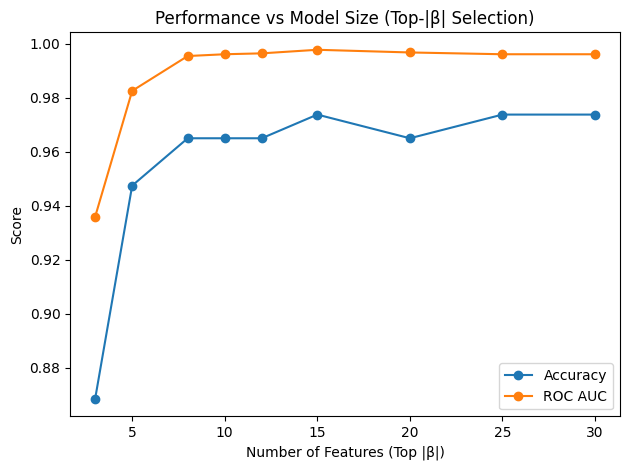

✅ Results saved to outputs/tables and outputs/figures
⚠️ No ablation plot created — core features not found in dataset.


In [15]:
# ============================================
# Feature Pruning & Ablation Experiments
# ============================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

# --- Safety checks ---
if "logreg" not in locals():
    raise RuntimeError("❌ 'logreg' model not found. Please rerun the logistic regression training cell first.")

if "coef_df" not in locals():
    print("⚠️ coef_df not found — rebuilding from fitted model.")
    coef = pd.Series(logreg.coef_[0], index=X.columns)
    coef_df = pd.DataFrame({
        "feature": X.columns,
        "beta": coef.values,
        "abs_beta": np.abs(coef.values)
    }).sort_values("abs_beta", ascending=False)

# --- Setup output folders ---
os.makedirs("outputs/figures", exist_ok=True)
os.makedirs("outputs/tables", exist_ok=True)

# --- Helper: train/eval on a chosen feature set ---
def train_eval_with_features(feature_list, name):
    Xtr = X_train[feature_list]
    Xte = X_test[feature_list]

    scaler_k = StandardScaler()
    Xtr_sc = scaler_k.fit_transform(Xtr)
    Xte_sc = scaler_k.transform(Xte)

    model = LogisticRegression(solver="liblinear", penalty="l2", max_iter=1000, random_state=42)
    model.fit(Xtr_sc, y_train)

    yhat = model.predict(Xte_sc)
    yproba = model.predict_proba(Xte_sc)[:, 1]

    return {
        "Scenario": name,
        "n_features": len(feature_list),
        "Accuracy": accuracy_score(y_test, yhat),
        "Precision": precision_score(y_test, yhat),
        "Recall": recall_score(y_test, yhat),
        "F1": f1_score(y_test, yhat),
        "ROC AUC": roc_auc_score(y_test, yproba)
    }

# --- Main experiment ---
coef_df_sorted = coef_df.sort_values("abs_beta", ascending=False)
all_features = coef_df_sorted["feature"].tolist()

results = []

# A) top-|β| feature selection
for k in [3, 5, 8, 10, 12, 15, 20, 25, len(all_features)]:
    feats = all_features[:k]
    results.append(train_eval_with_features(feats, name=f"Top-{k} |β|"))

# B) ablation: remove or isolate top predictors
core_feats = [f for f in ["worst radius", "worst perimeter", "worst concave points"] if f in all_features]
if core_feats:
    results.append(train_eval_with_features(core_feats, name=f"Only {', '.join(core_feats)}"))
    feats_drop = [f for f in all_features if f not in core_feats]
    results.append(train_eval_with_features(feats_drop, name=f"All minus {', '.join(core_feats)}"))

# Combine and save
res_df = pd.DataFrame(results).sort_values(["n_features", "Scenario"])
res_df.to_csv("outputs/tables/logreg_feature_pruning_results.csv", index=False)
display(res_df)

# --- Plot performance vs feature count ---
curve_df = res_df[res_df["Scenario"].str.startswith("Top-")]
plt.figure()
plt.plot(curve_df["n_features"], curve_df["Accuracy"], marker="o", label="Accuracy")
plt.plot(curve_df["n_features"], curve_df["ROC AUC"], marker="o", label="ROC AUC")
plt.xlabel("Number of Features (Top |β|)")
plt.ylabel("Score")
plt.title("Performance vs Model Size (Top-|β| Selection)")
plt.legend()
plt.tight_layout()
plt.savefig("outputs/figures/perf_vs_num_features.png", bbox_inches="tight")
plt.show()

print("✅ Results saved to outputs/tables and outputs/figures")
